In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

In [4]:
# Split dataset based on Age
df_under24 = df[df['Age'] < 24]
df_above24 = df[df['Age'] >= 24]


In [6]:
order = [
    'Insufficient_Weight',
    'Normal_Weight',
    'Overweight_Level_I',
    'Overweight_Level_II',
    'Obesity_Type_I',
    'Obesity_Type_II',
    'Obesity_Type_III'
]

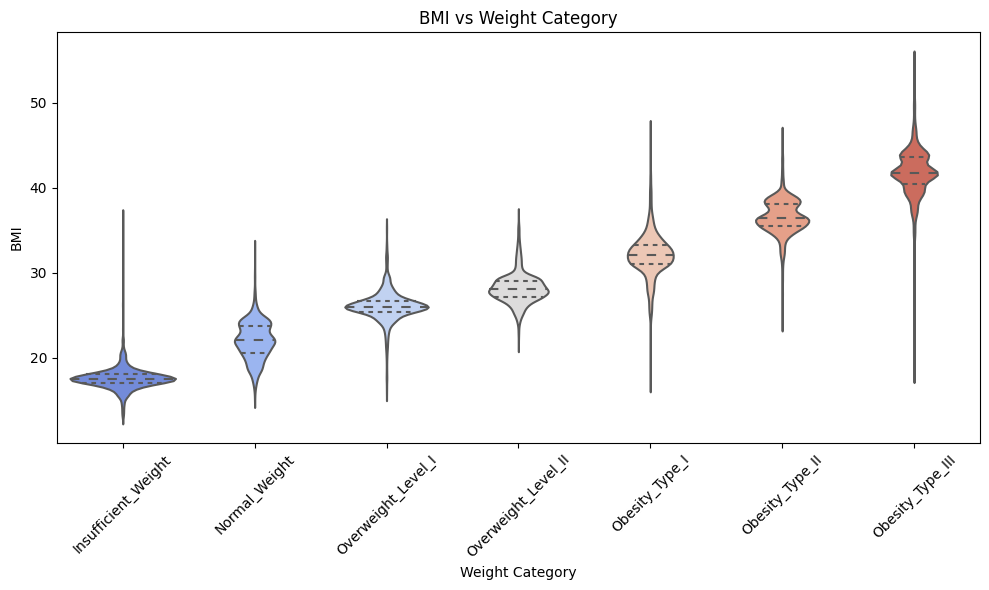

In [7]:
plt.figure(figsize=(10,6))
sns.violinplot(
    x='WeightCategory',
    y='BMI',
    data=df,
    order=order,
    inner='quartile',
    palette='coolwarm'
)
plt.title('BMI vs Weight Category')
plt.xlabel('Weight Category')
plt.ylabel('BMI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

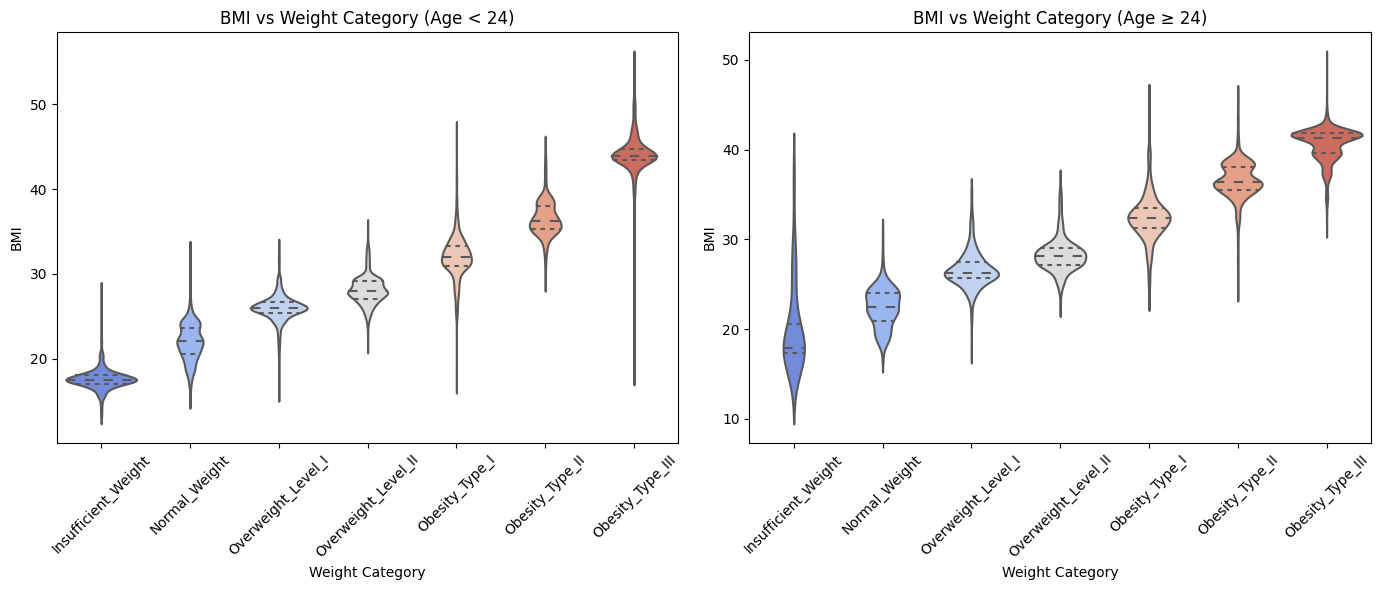

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 2 subplots
plt.figure(figsize=(14, 6))

# Plot 1 – Under 24
plt.subplot(1, 2, 1)
sns.violinplot(
    x='WeightCategory',
    y='BMI',
    data=df_under24,
    order=order,
    inner='quartile',
    palette='coolwarm'
)
plt.title('BMI vs Weight Category (Age < 24)')
plt.xlabel('Weight Category')
plt.ylabel('BMI')
plt.xticks(rotation=45)

# Plot 2 – 24 and Above
plt.subplot(1, 2, 2)
sns.violinplot(
    x='WeightCategory',
    y='BMI',
    data=df_above24,
    order=order,
    inner='quartile',
    palette='coolwarm'
)
plt.title('BMI vs Weight Category (Age ≥ 24)')
plt.xlabel('Weight Category')
plt.ylabel('BMI')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [13]:
df_under24['Age'] = df_under24['Age'].round().astype(int)
df_above24['Age'] = df_above24['Age'].round().astype(int)

C:\Users\surya\AppData\Local\Temp\ipykernel_20740\3335465459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_under24['Age'] = df_under24['Age'].round().astype(int)
C:\Users\surya\AppData\Local\Temp\ipykernel_20740\3335465459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_above24['Age'] = df_above24['Age'].round().astype(int)


In [22]:
order = [
    'Insufficient_Weight',
    'Normal_Weight',
    'Overweight_Level_I',
    'Overweight_Level_II',
    'Obesity_Type_I',
    'Obesity_Type_II',
    'Obesity_Type_III'
]

# Split dataset based on Age
df_under24 = df[df['Age'] < 24]
df_above24 = df[df['Age'] >= 24]

# Count per category
count_under24 = df_under24['WeightCategory'].value_counts()
count_above24 = df_above24['WeightCategory'].value_counts()

# Combine into a single DataFrame
count_df = pd.DataFrame({
    'Under 24': count_under24,
    '24 and Above': count_above24
}).fillna(0).astype(int)

# Reindex to follow the specified order
count_df = count_df.reindex(order)

# Add ratio column
count_df['Ratio (Under24 : 24+)'] = (
    count_df['Under 24'] / count_df['24 and Above'].replace(0, float('nan'))
).round(2)

# Display neatly
print(count_df)


                     Under 24  24 and Above  Ratio (Under24 : 24+)
WeightCategory                                                    
Insufficient_Weight      1841            29                  63.48
Normal_Weight            2065           280                   7.38
Overweight_Level_I       1434           410                   3.50
Overweight_Level_II      1049           832                   1.26
Obesity_Type_I           1556           651                   2.39
Obesity_Type_II           433          1970                   0.22
Obesity_Type_III         1057          1926                   0.55


In [23]:
# ==============================================
# End-to-end (Gender-Specific Models) + BMI feature:
# Load → Detect ID/Target/Gender → Drop MTRANS/SMOKE → +BMI → Age binarize →
# Split by Gender → Per-gender 5-Fold XGB (ES) → Predict → submission.csv
# ==============================================

# -------- Imports --------
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.base import clone

import xgboost as xgb

# -------- Paths --------
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
SAMPLE_SUB_PATH = "sample_submission.csv"

RANDOM_STATE = 42
N_FOLDS = 5
N_JOBS = -1
NUM_CLASSES_EXPECTED = 7   # used only for a sanity warning

# -------- Helpers --------
def norm_col(s: str) -> str:
    if s is None: return s
    return str(s).replace("\ufeff", "").strip().lower()

def build_norm_map(cols):
    fwd = {c: norm_col(c) for c in cols}
    rev = {}
    for orig, n in fwd.items():
        if n not in rev:
            rev[n] = orig
    return fwd, rev

def find_id_and_label(sample_sub, train, test):
    ss_fwd, ss_rev = build_norm_map(sample_sub.columns)
    tr_fwd, tr_rev = build_norm_map(train.columns)
    te_fwd, te_rev = build_norm_map(test.columns)

    ss_norm_cols = [ss_fwd[c] for c in sample_sub.columns]
    tr_norm_cols = [tr_fwd[c] for c in train.columns]
    te_norm_cols = [te_fwd[c] for c in test.columns]

    id_norm, label_norm = None, None
    if len(ss_norm_cols) == 2:
        c1, c2 = ss_norm_cols
        if c1 in te_norm_cols and c2 not in te_norm_cols:
            id_norm, label_norm = c1, c2
        elif c2 in te_norm_cols and c1 not in te_norm_cols:
            id_norm, label_norm = c2, c1
        else:
            if c1 in te_norm_cols and c1 in tr_norm_cols:
                id_norm, label_norm = c1, c2
            elif c2 in te_norm_cols and c2 in tr_norm_cols:
                id_norm, label_norm = c2, c1

    if id_norm is None:
        for cand in ["id", "row_id", "index", "sample_id"]:
            if cand in te_norm_cols and cand in tr_norm_cols:
                id_norm = cand
                break

    if label_norm is None:
        candidates = [c for c in ss_norm_cols if c != id_norm]
        if len(candidates) == 1:
            label_norm = candidates[0]

    if label_norm is None:
        for cand in ["label", "target", "class", "y", "weightcategory", "nobeyesdad"]:
            if cand in tr_norm_cols and cand != id_norm:
                label_norm = cand
                break

    if label_norm is None:
        for c in reversed(tr_norm_cols):
            if c != id_norm:
                label_norm = c
                break

    return {
        "id_norm": id_norm,
        "label_norm": label_norm,
        "id_in_train": build_norm_map(train.columns)[1].get(id_norm, None),
        "id_in_test": build_norm_map(test.columns)[1].get(id_norm, None),
        "id_in_sample": build_norm_map(sample_sub.columns)[1].get(id_norm, None),
        "label_in_train": build_norm_map(train.columns)[1].get(label_norm, None),
        "label_in_sample": build_norm_map(sample_sub.columns)[1].get(label_norm, None),
    }

def infer_feature_types(df):
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return num_cols, cat_cols

def detect_gender_column(df):
    # try common names
    candidates = [c for c in df.columns if norm_col(c) in {"gender","sex"}]
    if candidates:
        return candidates[0]
    # weak fallback: any column with two unique values that looks like M/F
    for c in df.columns:
        vals = pd.Series(df[c].dropna().astype(str).str.lower().str.strip()).unique()
        if len(vals) in (2, 3):
            if any(v.startswith("m") for v in vals) and any(v.startswith("f") for v in vals):
                return c
    return None

def split_by_gender(series):
    s = series.astype(str).str.lower().str.strip()
    male_mask = s.str.startswith(("m","1","true"))
    female_mask = s.str.startswith(("f","0","false"))
    if male_mask.sum()==0 and female_mask.sum()==0:
        top = s.value_counts().index.tolist()
        if len(top)>=2:
            male_mask = s==top[0]
            female_mask = s==top[1]
    return male_mask, female_mask

def add_bmi(df):
    """
    Compute BMI exactly as: BMI = Weight / (Height ** 2)
    Assumes Height is already in meters and Weight in kilograms.
    """
    if ("Weight" in df.columns) and ("Height" in df.columns):
        with np.errstate(divide="ignore", invalid="ignore"):
            df["BMI"] = df["Weight"].astype(float) / (df["Height"].astype(float) ** 2)
        df["BMI"] = df["BMI"].replace([np.inf, -np.inf], np.nan)
    return df

def binarize_age(df):
    """Overwrite Age to 0 if < 24 else 1."""
    if "Age" in df.columns:
        df["Age"] = (df["Age"].astype(float) >= 24).astype(np.int8)
    return df

# -------- Load data --------
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

# Drop not-used columns
for c in ["MTRANS","SMOKE"]:
    if c in train.columns: train.drop(columns=[c], inplace=True)
    if c in test.columns:  test.drop(columns=[c], inplace=True)

# >>> Add BMI feature (train & test) <<<
train = add_bmi(train)
test  = add_bmi(test)

# >>> Binarize Age as requested <<<
train = binarize_age(train)
test  = binarize_age(test)

info = find_id_and_label(sample_sub, train, test)

ID_COL_TRAIN   = info["id_in_train"]
ID_COL_TEST    = info["id_in_test"]
ID_COL_SAMPLE  = info["id_in_sample"]
TARGET_COL     = info["label_in_train"]
LABEL_COL_SAMP = info["label_in_sample"]

if TARGET_COL is None:
    raise ValueError("Could not detect the target column. Please ensure sample_submission and train headers align.")
if LABEL_COL_SAMP is None:
    ss_cols = list(sample_sub.columns)
    others = [c for c in ss_cols if c != ID_COL_SAMPLE]
    if len(others)==1:
        LABEL_COL_SAMP = others[0]
    else:
        raise ValueError("Could not detect label header in sample_submission.csv")

print(f"[Detected] Target in train: '{TARGET_COL}', Label in sample_sub: '{LABEL_COL_SAMP}'")
if ID_COL_TRAIN and ID_COL_TEST:
    print(f"[Detected] ID in train: '{ID_COL_TRAIN}', ID in test: '{ID_COL_TEST}'")

# -------- Target / Features --------
y = train[TARGET_COL].copy()
X = train.drop(columns=[TARGET_COL]).copy()
if ID_COL_TRAIN in X.columns:
    X.drop(columns=[ID_COL_TRAIN], inplace=True)

test_features = test.copy()
if ID_COL_TEST in test_features.columns:
    test_ids = test_features[ID_COL_TEST].copy()
    test_features.drop(columns=[ID_COL_TEST], inplace=True)
else:
    test_ids = pd.Series(np.arange(len(test_features)), name="id")

# -------- Label encode target --------
le = LabelEncoder()
y_enc = le.fit_transform(y)
classes = list(le.classes_)
if len(classes) != NUM_CLASSES_EXPECTED:
    print(f"[Warn] Expected {NUM_CLASSES_EXPECTED} classes but found {len(classes)}. Proceeding.")

# -------- Detect gender column and split --------
gender_col = detect_gender_column(pd.concat([X, test_features], axis=0))
if gender_col is None:
    raise ValueError("Could not detect a gender column (e.g., 'Gender' or 'SEX'). Please confirm the column name.")

male_mask, female_mask = split_by_gender(train[gender_col])
test_male_mask, test_female_mask = split_by_gender(test_features[gender_col])

print(f"[Info] Train male rows: {int(male_mask.sum())} | female rows: {int(female_mask.sum())}")
print(f"[Info] Test  male rows: {int(test_male_mask.sum())} | female rows: {int(test_female_mask.sum())}")

# We drop gender col inside each group (it's constant after split)
def train_group_and_predict(X_grp, y_enc_grp, test_grp, group_name):
    # remove gender from features
    cols_to_use = [c for c in X_grp.columns if c != gender_col]
    Xg = X_grp[cols_to_use].copy()
    Xtestg = test_grp[cols_to_use].copy()

    # feature types
    num_cols, cat_cols = infer_feature_types(Xg)

    # Preprocessor: sparse OHE (works with xgb DMatrix)
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False))
    ])
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe)
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols),
        ],
        remainder="drop",
        sparse_threshold=1.0
    )

    # XGBoost params
    xgb_params = {
        "objective": "multi:softprob",
        "num_class": len(classes),
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "max_depth": 6,
        "min_child_weight": 2,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "lambda": 1.0,
        "alpha": 0.0,
        "eta": 0.03,
        "nthread": N_JOBS,
        "seed": RANDOM_STATE,
    }
    NUM_BOOST_ROUND = 20000
    EARLY_STOP = 200

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    oof_group = np.zeros((len(Xg), len(classes)), dtype=np.float32)
    test_group_pred = np.zeros((len(Xtestg), len(classes)), dtype=np.float32)
    fold_best = []
    fold_metrics = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(Xg, y_enc_grp), start=1):
        print(f"\n[{group_name}] Fold {fold}/{N_FOLDS}")
        X_tr, X_va = Xg.iloc[tr_idx], Xg.iloc[va_idx]
        y_tr, y_va = y_enc_grp[tr_idx], y_enc_grp[va_idx]

        prep = clone(preprocessor)
        Xtr = prep.fit_transform(X_tr)
        Xva = prep.transform(X_va)

        dtrain = xgb.DMatrix(Xtr, label=y_tr)
        dval   = xgb.DMatrix(Xva, label=y_va)

        bst = xgb.train(
            params=xgb_params,
            dtrain=dtrain,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(dtrain, "train"), (dval, "valid")],
            early_stopping_rounds=EARLY_STOP,
            verbose_eval=False
        )
        best_round = int(bst.best_iteration + 1)
        fold_best.append(best_round)
        print(f"[{group_name}] Best iteration: {best_round}")

        oof_proba = bst.predict(dval, iteration_range=(0, best_round))
        oof_group[va_idx] = oof_proba
        oof_labels = np.argmax(oof_proba, axis=1)
        acc = accuracy_score(y_va, oof_labels)
        f1m = f1_score(y_va, oof_labels, average="macro")
        fold_metrics.append((acc, f1m))
        print(f"[{group_name}] Acc: {acc:.4f} | Macro F1: {f1m:.4f}")

        # test preds for this fold
        Xtest_tf = prep.transform(Xtestg)
        dtest = xgb.DMatrix(Xtest_tf)
        test_group_pred += bst.predict(dtest, iteration_range=(0, best_round)) / N_FOLDS

    # OOF summary for the group
    oof_argmax = np.argmax(oof_group, axis=1)
    acc_g = accuracy_score(y_enc_grp, oof_argmax)
    f1_g = f1_score(y_enc_grp, oof_argmax, average="macro")
    print(f"\n[{group_name}] OOF Accuracy: {acc_g:.4f} | Macro F1: {f1_g:.4f}")
    print(f"[{group_name}] Best iterations: {fold_best} | Median: {int(np.median(fold_best))}")

    return oof_group, test_group_pred

# -------- Run male model --------
X_male = X[male_mask].reset_index(drop=True)
y_male_enc = y_enc[male_mask]
test_male = test_features[test_male_mask].reset_index(drop=True)

male_oof, male_test_pred = train_group_and_predict(X_male, y_male_enc, test_male, "MALE")

# -------- Run female model --------
X_female = X[female_mask].reset_index(drop=True)
y_female_enc = y_enc[female_mask]
test_female = test_features[test_female_mask].reset_index(drop=True)

female_oof, female_test_pred = train_group_and_predict(X_female, y_female_enc, test_female, "FEMALE")

# -------- Combine OOF for overall report --------
oof_full = np.zeros((len(X), len(classes)), dtype=np.float32)
oof_full[male_mask.values] = male_oof
oof_full[female_mask.values] = female_oof

oof_labels = np.argmax(oof_full, axis=1)
oof_acc = accuracy_score(y_enc, oof_labels)
oof_f1 = f1_score(y_enc, oof_labels, average="macro")
print("\n========== OVERALL OOF ==========")
print(f"OOF Accuracy: {oof_acc:.4f} | OOF Macro F1: {oof_f1:.4f}")
try:
    print("\nOOF Classification Report:\n",
          classification_report(y_enc, oof_labels, target_names=classes))
except Exception as e:
    print(f"[Info] Could not print classification report: {e}")

# -------- Build full test predictions by placing group preds back to original order --------
test_pred_proba = np.zeros((len(test_features), len(classes)), dtype=np.float32)
test_pred_proba[test_male_mask.values] = male_test_pred
test_pred_proba[test_female_mask.values] = female_test_pred

test_pred_int = np.argmax(test_pred_proba, axis=1)
test_pred_labels = le.inverse_transform(test_pred_int)

# -------- Build submission --------
ss_cols = list(sample_sub.columns)
ID_HEADER = ID_COL_SAMPLE if ID_COL_SAMPLE in sample_sub.columns else None
LABEL_HEADER = LABEL_COL_SAMP

sub = pd.DataFrame()
if ID_HEADER is not None and ID_COL_TEST in test.columns:
    sub[ID_HEADER] = test[ID_COL_TEST].values
elif ID_HEADER is not None:
    sub[ID_HEADER] = np.arange(len(test_features))
sub[LABEL_HEADER] = test_pred_labels

# Reorder/complete to match sample_sub exactly
for c in ss_cols:
    if c not in sub.columns:
        sub[c] = sample_sub[c].iloc[0] if len(sample_sub[c]) else None
sub = sub[ss_cols]

sub.to_csv("submission.csv", index=False)
print("\nSaved submission.csv")
print(sub.head(10))


[Detected] Target in train: 'WeightCategory', Label in sample_sub: 'WeightCategory'
[Detected] ID in train: 'id', ID in test: 'id'
[Info] Train male rows: 7783 | female rows: 7750
[Info] Test  male rows: 2553 | female rows: 2672

[MALE] Fold 1/5


C:\Users\surya\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[MALE] Best iteration: 311
[MALE] Acc: 0.8857 | Macro F1: 0.7500

[MALE] Fold 2/5
[MALE] Best iteration: 299
[MALE] Acc: 0.8915 | Macro F1: 0.7561

[MALE] Fold 3/5
[MALE] Best iteration: 381
[MALE] Acc: 0.8831 | Macro F1: 0.7464

[MALE] Fold 4/5
[MALE] Best iteration: 315
[MALE] Acc: 0.8798 | Macro F1: 0.8669

[MALE] Fold 5/5
[MALE] Best iteration: 293
[MALE] Acc: 0.8747 | Macro F1: 0.7399

[MALE] OOF Accuracy: 0.8830 | Macro F1: 0.7471
[MALE] Best iterations: [311, 299, 381, 315, 293] | Median: 311

[FEMALE] Fold 1/5
[FEMALE] Best iteration: 338
[FEMALE] Acc: 0.9148 | Macro F1: 0.7495

[FEMALE] Fold 2/5
[FEMALE] Best iteration: 296
[FEMALE] Acc: 0.9187 | Macro F1: 0.7487

[FEMALE] Fold 3/5
[FEMALE] Best iteration: 241
[FEMALE] Acc: 0.9071 | Macro F1: 0.7370

[FEMALE] Fold 4/5
[FEMALE] Best iteration: 294
[FEMALE] Acc: 0.9123 | Macro F1: 0.7428

[FEMALE] Fold 5/5
[FEMALE] Best iteration: 319
[FEMALE] Acc: 0.9194 | Macro F1: 0.7549

[FEMALE] OOF Accuracy: 0.9145 | Macro F1: 0.7467
[FEMA